In [1]:
import os
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import cv2

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor


In [2]:
os.getcwd()

'/mnt/d/SKH'

In [3]:
dir = "/mnt/d/SKH/Github_Projects/DL_study/"
os.chdir(dir)
print(os.getcwd())
data_dir = 'data/MNIST'
train_df = pd.read_csv(os.path.join(data_dir,'mnist_train.csv'))
test_df = pd.read_csv(os.path.join(data_dir,'mnist_test.csv'))

/mnt/d/SKH/Github_Projects/DL_study


In [4]:
train_df.shape

(60000, 785)

In [5]:
X, y = train_df.iloc[:10001,1:].values, train_df.iloc[:10001,0].values
X.shape
train_df = train_df.iloc[:10001]

In [6]:
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tf=None, is_test=False):
        self.image_data = df.iloc[:,1:].values
        self.is_test = is_test
        self.encoder = None
        self.label_data = None
        if not self.is_test:
            self.encoder = LabelEncoder()
            labels = self.encoder.fit_transform(df.iloc[:,0])
            self.label_data = labels
        self.tf = tf
    def __len__(self):
        return len(self.image_data)
    def __getitem__(self, index):
        img = self.image_data[index]
        img = img.astype(np.uint8).reshape(28, 28)
        img = self.tf(img)
        if self.is_test:
            return img
        label = self.label_data[index]
        return img, label

In [7]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((231,231), interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idxs, val_idxs in skf.split(X,y):
    break

train_dataset = CustomDataset(train_df.iloc[train_idxs], tf=tf, is_test=False)
val_dataset = CustomDataset(train_df.iloc[val_idxs], tf=tf, is_test=False)
test_dataset = CustomDataset(test_df, tf=tf, is_test=True)

In [8]:
# DataLoader
batch_size = 256
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e5, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_state_dict = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state_dict = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model_state_dict = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights and self.best_model_state_dict is not None:
                    model.load_state_dict(self.best_model_state_dict )
                return True
        return False
        
    def restore_best(self, model):
        if self.best_model_state_dict is not None:
            model.load_state_dict(self.best_model_state_dict)
from tqdm import tqdm
def train(model, train_loader, criterion, optimizer, device='cpu'):
    # 1 epoch train cycle
    model.train()
    running_loss = 0.0
    correct = 0 # classification
    total = 0

    for train_x, train_y in train_loader: # batch training
        train_x, train_y = train_x.to(device), train_y.to(device)

        optimizer.zero_grad() # 이전 gradient 초기화
        # outputs = model(train_x)
        # loss = criterion(outputs, train_y)
					
        logits, probs = model(train_x) # classification
        loss = criterion(logits, train_y) # classification
        loss.backward() # backward pass
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item() # train_loss * batch_size
        _, predicted = torch.max(probs, 1) # 가장 확률 높은 클래스 예측 # classification
        correct += (predicted == train_y).sum().item() # classification
        total += train_y.size(0) 

    epoch_loss = running_loss / total # average loss of 1 epoch
    epoch_acc = 100 * correct / total # classification
    return epoch_loss , epoch_acc  # classification
def validate(model, val_loader, criterion, optimizer, device='cpu'):
    model.eval()  # 평가 모드
    val_loss = 0
    correct = 0 # classification
    total = 0

    with torch.no_grad():  # gradient 계산 비활성화
        for val_x, val_y in val_loader: # batch training
            val_x, val_y = val_x.to(device), val_y.to(device)
						
            # outputs = model(val_x)
            # loss = criterion(outputs, val_y)
					
            logits, probs = model(val_x) # classification
            loss = criterion(logits, val_y) # classification

            val_loss += loss.item()
            _, predicted = torch.max(probs, 1) # classification
            correct += (predicted == val_y).sum().item() # classification
            total += val_y.size(0)

    epoch_loss = val_loss / total # average loss of 1 epoch
    epoch_acc = 100 * correct / total # classification
    return epoch_loss , epoch_acc # classification

In [10]:
import os
os.getcwd()

'/mnt/d/SKH/Github_Projects/DL_study'

In [31]:
from codes.cv import spatial_pyramid_pool
class SPPNet(nn.Module):
    def __init__(self, n_classes, levels):
        # with respect to Overfeat-7
        super(SPPNet, self).__init__()
        self.total_bins = np.sum([level**2 for level in levels])
        self.feature_extractor = nn.Sequential(
            # [K, 231, 231] : K= #filters, H=Height, W=Width
            # H/W = floor({(H/W-F+2P)/stride})+1
            # pooling H/W = floor({(H/W-F)/2})+1
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=1), # [96, 28, 28]
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [96, 14, 14]
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1), # [256, 14, 14] # pad = floor(f/2) > 크기 유지
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [256, 7, 7]
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # [512, 7, 7]
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1), # [1024, 7, 7]
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1), # [1024, 7, 7]
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2), # [1024, 7, 7]
            spatial_pyramid_pool.SpatialPyramidPooling(levels=levels, mode='max') # 1024 * sum(level^2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # 
            nn.Linear(in_features=1024 * self.total_bins, out_features=3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=3072, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=4096, out_features=n_classes)
        )
    def forward(self, x):
        # print("1.",x.shape)
        x = self.feature_extractor(x)
        # print("2.",x.shape)
        logits = self.classifier(x)
        probs = logits.softmax(dim=1)
        return logits, probs


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
model = SPPNet(n_classes=10, levels=[1,2,3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, min_lr=5e-5)

In [34]:
# Full Implementation
# criterion, optimizer, scheduler, earlystopping 사용
EPOCHS = 1024
patience = 15
best_loss = float('inf')
epoch_counter = 0
done = False

es = EarlyStopping(patience=patience)
train_losses_for_plot, val_losses_for_plot = [], []
train_acc_for_plot, val_acc_for_plot = [], []
epoch_timer = []
while not done and epoch_counter<EPOCHS:
    st = time.time()
    epoch_counter += 1
    
    train_loss, train_acc = train( # classification
        model, train_loader, criterion, optimizer, device=device
    )
    train_losses_for_plot.append(train_loss)
    train_acc_for_plot.append(train_acc) # classification
        
    # validation
    val_loss, val_acc = validate( # classification
        model, val_loader, criterion, optimizer, device=device
    )
    val_losses_for_plot.append(val_loss)
    val_acc_for_plot.append(val_acc) # classification
    
    scheduler.step(val_loss) # scheduler의 종류에 따라 val_loss를 전달하거나 그냥 step() 호출.
    epoch_timer.append(time.time() - st)
    if es(model, val_loss):
        done = True
    if epoch_counter == 1 or epoch_counter % 5 == 0: # 50번째 epoch 마다
        mean_time_spent = np.mean(epoch_timer)
        epoch_timer = []
        print(f"Epoch {epoch_counter}/{EPOCHS} [Time: {mean_time_spent:.2f}s], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}\n Train ACC: {train_acc:.2f}, Validation ACC: {val_acc:.2f}") # classification

Epoch 1/1024 [Time: 95.87s], Train Loss: 0.0009, Validation Loss: 0.00916324
 Train ACC: 92.64, Validation ACC: 37.23
Epoch 5/1024 [Time: 27.63s], Train Loss: 0.0000, Validation Loss: 0.00020986
 Train ACC: 100.00, Validation ACC: 98.40
Epoch 10/1024 [Time: 16.23s], Train Loss: 0.0000, Validation Loss: 0.00019981
 Train ACC: 100.00, Validation ACC: 98.60
Epoch 15/1024 [Time: 17.47s], Train Loss: 0.0000, Validation Loss: 0.00020805
 Train ACC: 100.00, Validation ACC: 98.60


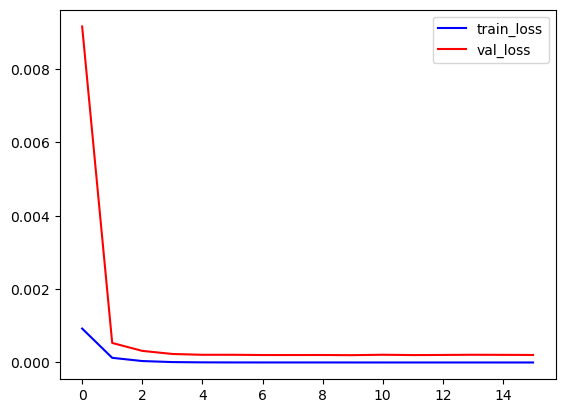

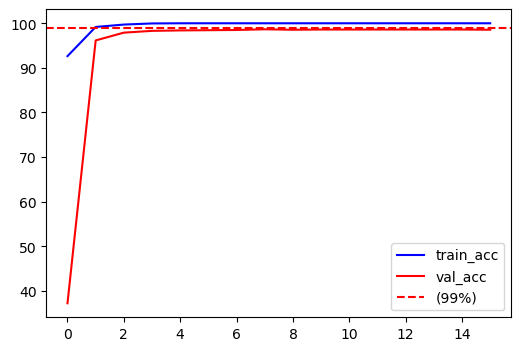

In [35]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses_for_plot)),train_losses_for_plot,color='blue',label='train_loss')
plt.plot(range(len(val_losses_for_plot)),val_losses_for_plot,color='red',label='val_loss')
plt.legend()

# run.log({'loss_plot': wandb.Image(fig)}) # wandb

# classification
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(range(len(train_acc_for_plot)),train_acc_for_plot,color='blue',label='train_acc')
plt.plot(range(len(val_acc_for_plot)),val_acc_for_plot,color='red',label='val_acc')
plt.axhline(y=99.0, color='red', linestyle='--', label='(99%)')
plt.legend()

# run.log({'accuracy_plot': wandb.Image(fig)}) # wandb

plt.show()

In [36]:
# load best model
es.restore_best(model)

model.eval()
preds = []
with torch.no_grad():
    for img in test_loader:
        img = img.to(device)
        logits, probs = model(img)
        _, predicted = torch.max(probs, dim=1)
        preds.extend(predicted.cpu().numpy())

pred_labels = train_dataset.encoder.inverse_transform(preds)

In [37]:
gt = test_df['label'].values
gt_label = train_dataset.encoder.inverse_transform(gt)

test_correct = (gt == preds).sum().item()
test_acc = (test_correct/len(gt))*100
print(f"test accuracy: {test_acc:.3f}%")

test accuracy: 36.960%


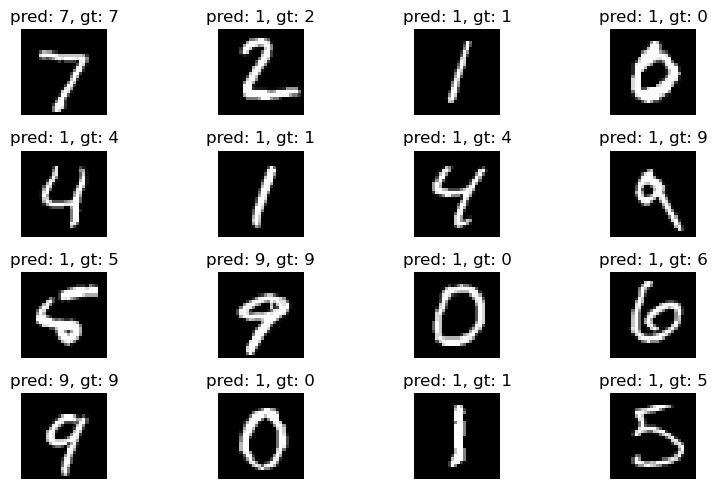

In [38]:
images = next(iter(test_loader))
fig = plt.figure(figsize=(10,5))
for i in range(16):
    fig.add_subplot(4,4, i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'pred: {pred_labels[i]}, gt: {gt_label[i]}')
plt.show()